# 🚀 Notebook 2: Enhancing Predictions with Pseudo Labels

Welcome to the second part of this solution for the **TechCabal Ewè Audio Translation Challenge**! In this notebook, we'll build on the foundation laid in **Notebook 1** by utilizing **pseudo labels** to further improve the model's performance.

In **Notebook 1**, we covered the following steps:
- Preprocessing the audio data.
- Extracting MFCC features.
- Training a custom model (**FemiNet**).
- Making predictions and generating a submission file.

Now, in **Notebook 2**, we'll take predictions with high confidence from the model and use them as pseudo labels to retrain the model. This technique helps to make better use of the test data and can significantly boost the model's accuracy.

Here's what we'll cover:
1. 📥 **Load Stage 1 Predictions** – Bring in the predictions from the first notebook.
2. 🧪 **Select Confident Predictions** – Identify test samples with a high confidence score to use as pseudo labels.
3. 🧠 **Retrain the Model** – Combine the training data with pseudo-labeled data to retrain the model.
4. 🎯 **Make Final Predictions** – Generate improved predictions using the retrained model.
5. 📝 **Prepare Final Submission** – Submit the enhanced predictions to Zindi.

Let's get started! 🚀


### 🖼️ Pictorial Representation of Stage 2

The visual representation of **Stage 2** is shown below.


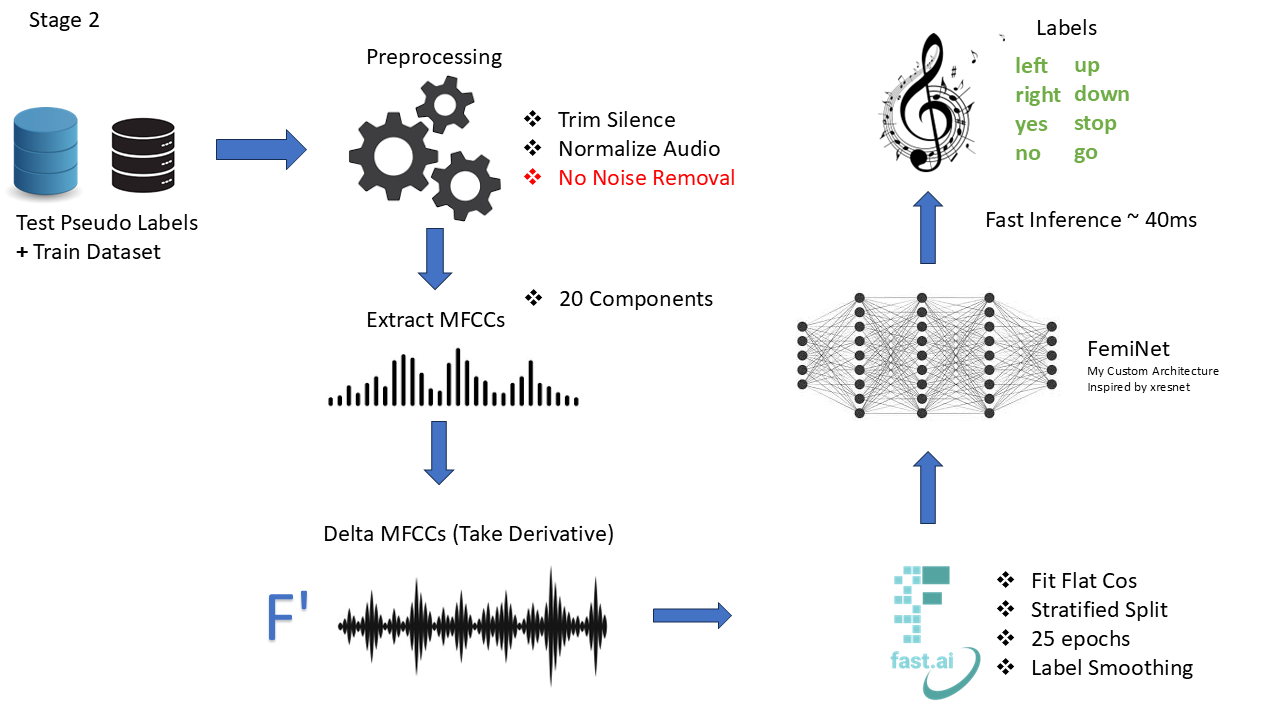

### 📁 Data Loading and Setup (Stage 2)

In [1]:
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
from fastai.vision.all import *

# Load train and test data
train = pd.read_csv("/kaggle/input/techcabal-audio-dataset/files/Train.csv")
test = pd.read_csv("/kaggle/input/techcabal-audio-dataset/files/Test_1.csv")
ss = pd.read_csv("/kaggle/input/techcabal-audio-dataset/files/SampleSubmission_1.csv")

# Define the folder where audio files are stored
AUDIO_FOLDER = "/kaggle/input/techcabal-audio-dataset/audio/TechCabal Ewe Audio Files"

# Check the available classes
classes = train['class'].unique()
print(f"Classes: {classes}")


Classes: ['left' 'down' 'go' 'right' 'up' 'yes' 'no' 'stop']


### 📥 Download Pseudo Labels

Download the **pseudo labels file** from the output folder of **Notebook 1** if you're running this notebook on a platform like Kaggle. If you're running locally, you can skip this step. Otherwise, use the appropriate download link provided in Notebook .


In [2]:
!wget "https://www.kaggleusercontent.com/kf/198465882/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..LRzVsgPppjlBDXaLGVOCtw.G4WQ_OoEUk3Ezn6mK7ddXFt83Y48tdlVpdZ2LGarLZO31jzqj8QZa0oQ2oRhtwhfstS6mgzGMjRaRQVPnpxkrmhF6oNTVEzDgT2h9t7oMQkvvDqS3RCOvGqgBm_FKSb4f8YZPnzYUYvnpihM91QCDAx1kOLFR6SLjcjeOWzESPxtAqNvJyv06mxVBFWc7NHfuM5Iq0MnFlv8A1jl_wI7m7LyGS1moONY1Yw0Jq_has94DVjaIltPGskpjeJLhVi1kOZulo0Id4uk7UN0cIVFWjA2ghBXPHS4WZuS4kWGxWfdBu-6QURvdjQWHVCE9Ge2X8No4W-VcLeS_jG6kfWP61G1nc1l9vkRirbmDJw1CHuMvBzNm2pGPtUCQOJKDRlutQv5nqFTwCptvRop77OGbMtU8LU5ATR0VNTKRpjaHYV8FcCCUCNX4ggxdME-CqqICacGLVpPWI9BSVWCsEBcUqQryGmMk-gsbbZxOrZZEZm6c-IXKAiW4vjb-wijHbhbOz4N5hBugtBNSHEkZTESYo0CuHIFH6ijtEkiFJIVwKPwbMuu9FbMdx2q3r2i3kNtm5mC4gstYCY0_6RftBYWxrekUL_Sri1OgqnVTQNpDYkgSzQb7MTvR6WQGFwD9uai.A7IEo7F64od3HqI-fb85Ew/probabilities_submission.csv"

--2024-09-29 23:44:34--  https://www.kaggleusercontent.com/kf/198465882/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..LRzVsgPppjlBDXaLGVOCtw.G4WQ_OoEUk3Ezn6mK7ddXFt83Y48tdlVpdZ2LGarLZO31jzqj8QZa0oQ2oRhtwhfstS6mgzGMjRaRQVPnpxkrmhF6oNTVEzDgT2h9t7oMQkvvDqS3RCOvGqgBm_FKSb4f8YZPnzYUYvnpihM91QCDAx1kOLFR6SLjcjeOWzESPxtAqNvJyv06mxVBFWc7NHfuM5Iq0MnFlv8A1jl_wI7m7LyGS1moONY1Yw0Jq_has94DVjaIltPGskpjeJLhVi1kOZulo0Id4uk7UN0cIVFWjA2ghBXPHS4WZuS4kWGxWfdBu-6QURvdjQWHVCE9Ge2X8No4W-VcLeS_jG6kfWP61G1nc1l9vkRirbmDJw1CHuMvBzNm2pGPtUCQOJKDRlutQv5nqFTwCptvRop77OGbMtU8LU5ATR0VNTKRpjaHYV8FcCCUCNX4ggxdME-CqqICacGLVpPWI9BSVWCsEBcUqQryGmMk-gsbbZxOrZZEZm6c-IXKAiW4vjb-wijHbhbOz4N5hBugtBNSHEkZTESYo0CuHIFH6ijtEkiFJIVwKPwbMuu9FbMdx2q3r2i3kNtm5mC4gstYCY0_6RftBYWxrekUL_Sri1OgqnVTQNpDYkgSzQb7MTvR6WQGFwD9uai.A7IEo7F64od3HqI-fb85Ew/probabilities_submission.csv
Resolving www.kaggleusercontent.com (www.kaggleusercontent.com)... 35.190.26.106
Connecting to www.kaggleusercontent.com (www.kaggleusercontent.com)|35.190.26.106|

### 📄 Loading Pseudo Labels

In [3]:
pseudo = pd.read_csv("/kaggle/working/probabilities_submission.csv")
pseudo.head()

,id,class,probabilities
0,id_u5iqtgjzhx,up,0.842974
1,id_l7ebzcfk5e,down,0.962352
2,id_jbzci8uepl,no,0.851042
3,id_jzil0fw5vs,yes,0.307237
4,id_o7mrvf5wj7,left,0.984474


### 🎯 Filtering High-Confidence Pseudo Labels
- Filtered the pseudo labels to retain only those with a confidence score greater than **0.90**.

In [4]:
pseudos = pseudo[pseudo["probabilities"]>0.90]
pseudos.head()

,id,class,probabilities
1,id_l7ebzcfk5e,down,0.962352
4,id_o7mrvf5wj7,left,0.984474
5,id_zml59lrcpw,no,0.999852
8,id_y00w6u4d3r,no,0.988828
10,id_55d0coqx4a,yes,0.981666


In [5]:
x = pseudos.drop("probabilities", axis=1).reset_index(drop=True)
x["audio_filepath"] = x["id"] + ".wav"
x["duration"] = 3

x

,id,class,audio_filepath,duration
0,id_l7ebzcfk5e,down,id_l7ebzcfk5e.wav,3
1,id_o7mrvf5wj7,left,id_o7mrvf5wj7.wav,3
2,id_zml59lrcpw,no,id_zml59lrcpw.wav,3
3,id_y00w6u4d3r,no,id_y00w6u4d3r.wav,3
4,id_55d0coqx4a,yes,id_55d0coqx4a.wav,3
...,...,...,...,...
2398,id_gx8hrglpc9,left,id_gx8hrglpc9.wav,3
2399,id_9bxbutuh8z,left,id_9bxbutuh8z.wav,3
2400,id_d0tudlf5gn,left,id_d0tudlf5gn.wav,3
2401,id_xuwlsfztrd,right,id_xuwlsfztrd.wav,3


In [6]:
x = x[['id', 'audio_filepath', 'duration', 'class']]
x

,id,audio_filepath,duration,class
0,id_l7ebzcfk5e,id_l7ebzcfk5e.wav,3,down
1,id_o7mrvf5wj7,id_o7mrvf5wj7.wav,3,left
2,id_zml59lrcpw,id_zml59lrcpw.wav,3,no
3,id_y00w6u4d3r,id_y00w6u4d3r.wav,3,no
4,id_55d0coqx4a,id_55d0coqx4a.wav,3,yes
...,...,...,...,...
2398,id_gx8hrglpc9,id_gx8hrglpc9.wav,3,left
2399,id_9bxbutuh8z,id_9bxbutuh8z.wav,3,left
2400,id_d0tudlf5gn,id_d0tudlf5gn.wav,3,left
2401,id_xuwlsfztrd,id_xuwlsfztrd.wav,3,right


In [7]:
train.head()

,id,audio_filepath,duration,class
0,id_6nazjwygdl,id_6nazjwygdl.wav,1.984,left
1,id_jpwl97yilf,id_jpwl97yilf.wav,2.027,down
2,id_9d131fb32p,id_9d131fb32p.wav,2.274,go
3,id_kat2oty4s0,id_kat2oty4s0.wav,2.176,down
4,id_g3hvae3jbe,id_g3hvae3jbe.wav,1.634,down


### 🧩 Merging Pseudo Labels with Training Data

In [8]:
train = pd.concat([train,x]).reset_index(drop=True)
train.head()

,id,audio_filepath,duration,class
0,id_6nazjwygdl,id_6nazjwygdl.wav,1.984,left
1,id_jpwl97yilf,id_jpwl97yilf.wav,2.027,down
2,id_9d131fb32p,id_9d131fb32p.wav,2.274,go
3,id_kat2oty4s0,id_kat2oty4s0.wav,2.176,down
4,id_g3hvae3jbe,id_g3hvae3jbe.wav,1.634,down


In [9]:
!pip install noisereduce -q

### 🎧 Audio Loading and Preprocessing

- `load_and_preprocess`: A function that:
  - Loads an audio file with a sample rate of 16kHz.
  - Trims any silence from the beginning and end of the audio.
  - Normalizes the .ency.


In [10]:
import librosa.effects
import noisereduce as nr  # For noise reduction

def load_and_preprocess(filepath, sr=16000):
    # Load the audio file
    audio, sample_rate = librosa.load(filepath, sr=sr)
    
    # Trim silence from the beginning and end
    audio, _ = librosa.effects.trim(audio)
    
    # Normalize the audio to have values between -1 and 1
    audio = librosa.util.normalize(audio)
    return audio, sample_rate


### 🔍 MFCC Extraction and Visualization

- `extract_mfcc`: A function that extracts **MFCC** (Mel Frequency Cepstral Coefficients) from the audio and computes their delta (rate of change).
- `plot_mfcc`: Visualizes the extracted MFCCs using `librosa.displais.


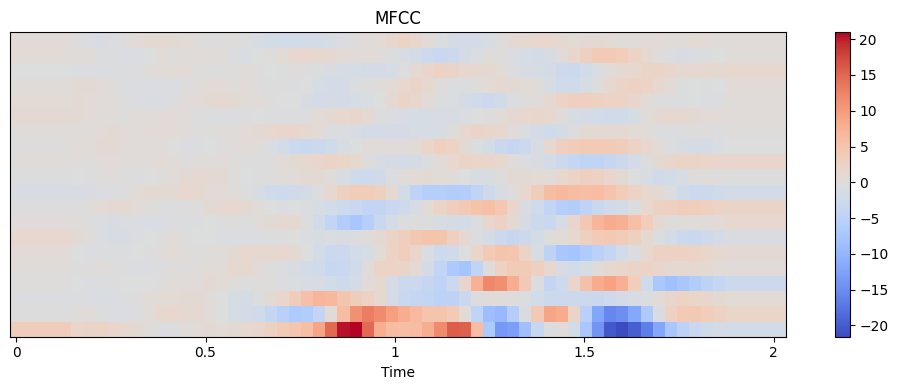

In [11]:
def extract_mfcc(audio, sr=16000, n_mfcc=20):
    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfcc = librosa.feature.delta(mfcc)
    return mfcc

def plot_mfcc(mfcc, sr=16000):
    # Visualize MFCCs
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc, sr=sr, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')
    plt.tight_layout()
    plt.show()

# Example to test preprocessing and MFCC extraction
audio, sr = load_and_preprocess(f"{AUDIO_FOLDER}/{train['audio_filepath'].iloc[1]}")
mfcc = extract_mfcc(audio, sr)
plot_mfcc(mfcc)



### 📏 Padding/Trimming MFCC and Audio-to-MFCC Transform
- `AudioToMFCC`: A custom transform that:
  - Loads and preprocesses the audio file.
  - Extracts MFCC features and applies padding/trimming to maintain a uniform input size.
  - Adds a channel dimension to the MFCC tensor for compatibility with Convolutional Neural Networks (CNNs).

- `pad_or_trim`: A function that ensures all MFCCs have a fixed length, either by cropping or padding with zeros.

In [12]:
import torch

# Function to pad or crop MFCC to a fixed size (e.g., 128 time steps)
def pad_or_trim(mfcc, fixed_length=256):
    # Get the current length of the time dimension
    current_length = mfcc.shape[-1]

    if current_length > fixed_length:
        # Crop if the MFCC is longer than the fixed size
        return mfcc[:, :fixed_length]
    elif current_length < fixed_length:
        # Pad with zeros if the MFCC is shorter than the fixed size
        pad_amount = fixed_length - current_length
        return torch.nn.functional.pad(mfcc, (0, pad_amount), mode='constant')
    else:
        # If the size matches, return as is
        return mfcc

# Modify the AudioToMFCC transform to include padding/cropping
class AudioToMFCC(Transform):
    def __init__(self, folder, fixed_length=256):
        self.folder = folder
        self.fixed_length = fixed_length

    def encodes(self, row):
        file_path = f"{self.folder}/{row['audio_filepath']}"
        audio, sr = load_and_preprocess(file_path)
        mfcc = extract_mfcc(audio, sr)
        
        # Ensure all MFCC tensors have the same time dimension
        mfcc = pad_or_trim(tensor(mfcc), self.fixed_length)
        
        return mfcc.unsqueeze(0)  # Add channel dimension for CNN
    
    def decodes(self, x):
        return x



### 📊 DataBlock and DataLoaders Setup

- Defined the path to the audio files and set a fixed length for MFCC time steps (128).
- Created an `AudioToMFCC` transform to preprocess audio and extract MFCC features.
- Built a `DataBlock` with:
  - MFCC features as input (`TransformBlock`).
  - The class labels as output (`CategoryBlock`).
  - A training-validation split with 10% validation data, stratified by class.
- Created `DataLoaders` with a batch si.idation.


In [13]:
# Define the path to audio files
aud_fold = "/kaggle/input/techcabal-audio-dataset/audio/TechCabal Ewe Audio Files/"

# Set the fixed length for MFCC time steps
fixed_length = 128  # You can experiment with this size

# Instantiate the custom transform to use in the DataBlock
audio_transform = AudioToMFCC(aud_fold, fixed_length=fixed_length)

# Define a DataBlock that uses our custom audio transform
audio_block = DataBlock(
    blocks=(TransformBlock(type_tfms=audio_transform), CategoryBlock),
    get_x=lambda r: r,  # Get full row, transformation is handled by `audio_transform`
    get_y= ColReader('class'),  # Get the class (e.g., 'left', 'right', etc.)
    splitter=TrainTestSplitter(0.1, stratify=train["class"])  # Split data into training and validation sets
)

# Create the DataLoaders
dls = audio_block.dataloaders(train, bs=32)

### 🖼️ Visualizing MFCCs from a DataLoader

- `show_mfcc_batch`: A custom function to display a batch of MFCCs from the DataLoader.
  - Retrieves one batch of data, removes the channel dimenson, and converts the MFCCs to NumPy format.
  - Plots the MFCCs in a grid, with each plot showing the corresponding label.
- Visualized 4 MFCCs from the training DataLoader to inspect the feature representations.


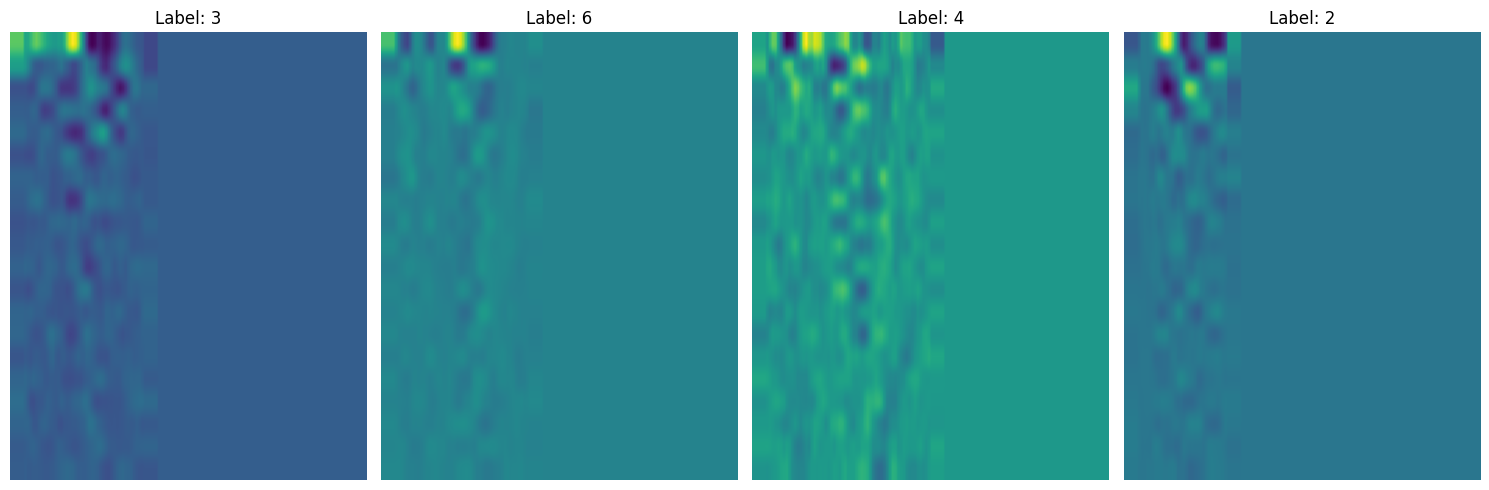

In [14]:
import matplotlib.pyplot as plt

# Custom function to display a batch of MFCCs
def show_mfcc_batch(dl, n=4):
    """Displays a batch of MFCCs from the DataLoader"""
    xb, yb = dl.one_batch()  # Get one batch of data
    fig, axs = plt.subplots(1, n, figsize=(15, 5))

    for i in range(n):
        mfcc = xb[i].squeeze(0).cpu().numpy()  # Remove channel dimension, convert to numpy
        axs[i].imshow(mfcc, cmap='viridis', aspect='auto')
        axs[i].set_title(f"Label: {yb[i].item()}")
        axs[i].set_axis_off()

    plt.tight_layout()
    plt.show()

# Use the custom show function to display MFCCs from the DataLoader
show_mfcc_batch(dls.train, n=4)


### 🧠 FemiNet: My Custom CNN Architecture

In [19]:
import torch
import torch.nn as nn
from fastai.vision.all import *

class FemiNet(nn.Module):
    def __init__(self, num_classes):
        super(FemiNet, self).__init__()
        self.features = nn.Sequential(
            # Increase input/output channels for a larger model
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Adding more residual blocks with increased channels
            self._make_layer(64, 128, 2),
            self._make_layer(128, 256, 1),
#             self._make_layer(256, 512, 1),
            
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks):
        layers = []
        for _ in range(blocks):
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
            in_channels = out_channels
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Number of classes should match your dataset
model = FemiNet(num_classes=len(dls.vocab))

learn = Learner(dls, model, LabelSmoothingCrossEntropyFlat(), metrics=accuracy)

### 🚀 Model Training

- Trained the **FemiNet** model using **FastAI's `fit_flat_cos`** method for 25 epochs.
  - The **flat cosine annealing** schedule helps in achieving better convergence by flattening the learning rate during training and then reducing it smoothly at the end.


In [22]:
learn.fit_flat_cos(
    25
)


epoch,train_loss,valid_loss,accuracy,time
0,1.211995,1.072377,0.745478,04:33
1,0.846726,1.205016,0.715762,03:57
2,0.679618,1.093053,0.724806,03:56
3,0.585031,0.966049,0.780362,03:59
4,0.536440,0.688036,0.941860,03:57
5,0.511701,0.685308,0.943152,03:56
6,0.497275,0.525122,0.998708,03:57
7,0.490871,0.747009,0.897933,03:58
8,0.492294,0.764592,0.894057,03:58
9,0.488340,0.585068,0.975452,03:56


### 🔍 Inference Stage

- During the inference stage, we apply the trained **FemiNet** model to the test audio files:
  - Preprocess the audio by trimming silence, normalizing, and extracting Delta MFCC features.
  - The processed audio is then passed through the trained model to generate predictions.
  - The predictions are used to classify each audio file into its corresponding class.


In [23]:
test = pd.read_csv("/kaggle/input/techcabal-audio-dataset/files/Test_1.csv")
test.head()

,id,audio_filepath,duration
0,id_u5iqtgjzhx,id_u5iqtgjzhx.wav,2.35800
1,id_l7ebzcfk5e,id_l7ebzcfk5e.wav,3.22100
2,id_jbzci8uepl,id_jbzci8uepl.wav,2.94898
3,id_jzil0fw5vs,id_jzil0fw5vs.wav,4.33100
4,id_o7mrvf5wj7,id_o7mrvf5wj7.wav,1.85600


### 🎯 Inference Function for Single Audio File

- `predict_audio`: A function that processes a single audio file for inference.
  - Loads and preprocesses the audio (trimming silence, normalization).
  - Extracts MFCC features.
  - Converts the MFCCs into a tensor format compatible with the CNN (adding a channel dimension).
  - Passes the processed MFCC through the trained model to generate predictions, returning the predicted class, index, and output probabilities.


In [24]:
# Define a function to handle inference for a single audio file
def predict_audio(filepath):
    # Load and preprocess the audio file
    audio, sr = load_and_preprocess(filepath)
    
    # Extract MFCC features
    mfcc = extract_mfcc(audio, sr)
    
    # Convert MFCC into a format suitable for the FastAI model (tensor)
    mfcc_tensor = tensor(mfcc).unsqueeze(0)  # Add channel dimension for CNN (1, channels, height, width)
    
    # Get prediction
    pred_class, pred_idx, outputs = learn.predict(mfcc_tensor)
    
    return pred_class, pred_idx, outputs

### 💾 Saving the Model Weights - 6.5mb

In [26]:
# Save model weights
learn.save('mini_audio_classifier_weights')

Path('models/mini_audio_classifier_weights.pth')

### 📝 Generating Predictions and Preparing Submission

In [27]:
%%capture
# Generate predictions
preds = []
for x in test['audio_filepath'].tolist():
    pred_class, _, _ = predict_audio(f"{AUDIO_FOLDER}/{x}")
    preds.append(pred_class)

# Assign predictions to the test dataframe
test['pred'] = preds

# Prepare submission file
submission = test[['id', 'pred']].rename(columns={'pred': 'class'})
submission.to_csv('submission.csv', index=False)

### ⏱️ Calculating Test Time Speed

- Used the **ThreadPoolExecutor** to parallelize the inference process for multiple audio files, allowing faster predictions by utilizing multiple CPU cores.
  - Defined a `process_audio` function to handle the prediction for each audio file.
- Calculated the total inference time by measuring the start and end times.


In [28]:
%%capture
import time
from concurrent.futures import ThreadPoolExecutor, as_completed

# Function to process each audio file
def process_audio(filepath):
    pred_class, _, _ = predict_audio(f"{AUDIO_FOLDER}/{filepath}")
    return pred_class

# Prepare the audio file list
audio_files = test['audio_filepath'].tolist()
total_files = len(audio_files)

# Start timer
start_time = time.time()

# Use ThreadPoolExecutor for parallel processing
preds = []
with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust number of workers based on your CPU
    futures = [executor.submit(process_audio, x) for x in audio_files]

# End timer
end_time = time.time()

### ⏱️ Inference Time Results

- **Total number of files**: 2946
- **Total execution time**: ~ 2 minutes
- **Average time per file**: 0.04 seconds
- **Average time per file (milliseconds)**: 41.43 milliseconds

These results show the efficiency of the model during inference, with an average processing time of around 40 milliseconds per file, making it suitable for real-time or near real-time applications.


In [29]:
# Calculate total time in minutes and average time per file
total_time = end_time - start_time
average_time_per_file = total_time / total_files

# Print statistics
print(f"Total number of files: {total_files}")
print(f"Total execution time: {total_time / 60:.2f} minutes")
print(f"Average time per file: {average_time_per_file:.2f} seconds")
print(f"Average time per file (milliseconds): {average_time_per_file*1000:.2f} milliseconds")


Total number of files: 2946
Total execution time: 2.03 minutes
Average time per file: 0.04 seconds
Average time per file (milliseconds): 41.43 milliseconds


### 🔚 The End

This concludes the second notebook. We successfully enhanced our model using pseudo labels, improved inference speed, and prepared our final submission. Thank you for following along!


I am always open to assist enthusiasts with difficulties they are facing in Machine learning and Deep learning. Feel free to reach out to me: most preferably LinkedIn.

. [Twitter](https://twitter.com/olufemivictort).

. [Linkedin](https://www.linkedin.com/in/olufemi-victor-tolulope).

. [Github](https://github.com/osinkolu)

### Author: Olufemi Victor Tolulope